In [97]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
import cv2

In [98]:
# Caminho para o diretório que contém as subpastas 'comestivel' e 'venenoso'

data_dir = r'C:\GitHub\MushroomClassification\Mushrooms'

def verify_images(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                img = Image.open(file_path)
                img.verify()  # Verifica a integridade da imagem
            except (IOError, SyntaxError) as e:
                print(f"Imagem corrompida detectada e removida: {file_path}")
                os.remove(file_path)

 Executa a verificação

verify_images(data_dir)

In [99]:
# Função para converter as imagens para o formato PNG
def convert_image_format(image_path, output_path):
    try:
        img = Image.open(image_path)
        img.save(output_path, 'PNG')
    except Exception as e:
        print(f"Erro ao converter a imagem {image_path}: {e}")

In [100]:
# Converter todas as imagens no diretório de forma recursiva
def convert_images_in_directory(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            if file_path.endswith('.jpg') or file_path.endswith('.jpeg'):
                output_path = file_path.replace('.jpg', '.png').replace('.jpeg', '.png')
                convert_image_format(file_path, output_path)

In [101]:
# Converter as imagens antes de carregar para o modelo
convert_images_in_directory(data_dir)

In [102]:
# Configuração do Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.3,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode = 'nearest'
)

In [103]:
# Geradores de treinamento e validação
train_generator = train_datagen.flow_from_directory(
    data_dir,  # substitua pelo caminho do diretório com as imagens
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
)

Found 9057 images belonging to 9 classes.


In [104]:
validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
)

Found 3875 images belonging to 9 classes.


In [105]:
# Carregar o modelo base VGG16 pré-treinado
base_model = VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = True
for layer in base_model.layers[:-4]:  # Mantenha as primeiras camadas congeladas, descongelando apenas as últimas 4
    layer.trainable = False


In [106]:
# Construir o modelo completo
model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(9, activation='softmax')
])

In [107]:
# Compilação do modelo
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,  # Aumente o número de épocas
    callbacks=[early_stopping]
)

c:\GitHub\MushroomClassification\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 2640s 9s/step - accuracy: 0.2633 - loss: 2.0200 - val_accuracy: 0.4586 - val_loss: 1.5008
Epoch 2/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 2624s 9s/step - accuracy: 0.5125 - loss: 1.3816 - val_accuracy: 0.3894 - val_loss: 1.7023
Epoch 3/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 3157s 11s/step - accuracy: 0.5815 - loss: 1.1892 - val_accuracy: 0.5874 - val_loss: 1.1864
Epoch 4/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 2901s 10s/step - accuracy: 0.6893 - loss: 0.9145 - val_accuracy: 0.6186 - val_loss: 1.0946
Epoch 5/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 2802s 10s/step - accuracy: 0.7412 - loss: 0.7600 - val_accuracy: 0.6168 - val_loss: 1.2044
Epoch 6/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 2799s 10s/step - accuracy: 0.7781 - loss: 0.6548 - val_accuracy: 0.6250 - val_loss: 1.2137
Epoch 7/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 2515s 9s/step - accuracy: 0.7923 - loss: 0.6007 - val_accuracy: 0.6655 - val_loss: 1.0960
Epoch 8/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 2417s 9s/step - accuracy: 0.8304 - loss: 0.502

In [108]:
# Avaliação
loss, accuracy = model.evaluate(validation_generator)
print(f"Acurácia: {accuracy * 100:.2f}%")


122/122 ━━━━━━━━━━━━━━━━━━━━ 715s 6s/step - accuracy: 0.6153 - loss: 1.1088
Acurácia: 61.60%


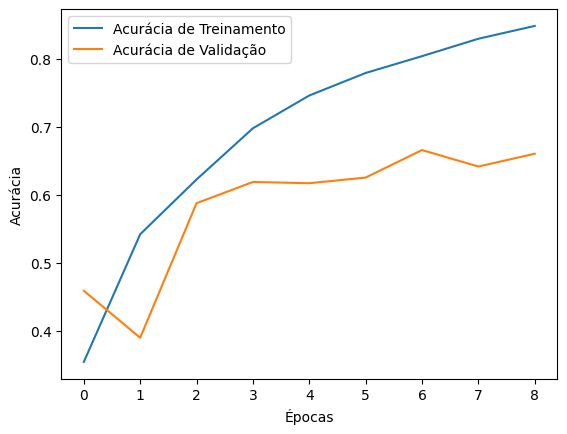

In [109]:
# Visualizando a perda e acurácia
plt.plot(history.history['accuracy'], label='Acurácia de Treinamento')
plt.plot(history.history['val_accuracy'], label='Acurácia de Validação')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

### Avaliando resultados treino

In [111]:
#Matrix de Confusão
Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)

122/122 ━━━━━━━━━━━━━━━━━━━━ 868s 7s/step


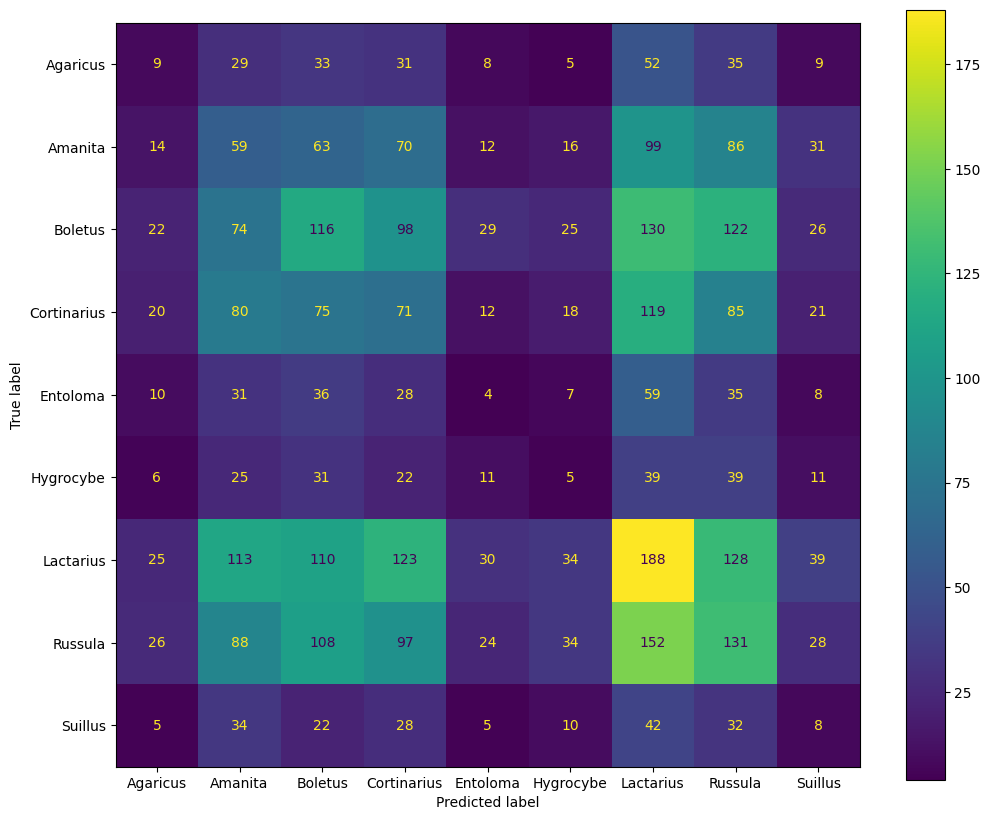

In [112]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
class_labels = ['Agaricus', 'Amanita', 'Boletus', 'Cortinarius', 'Entoloma', 'Hygrocybe', 'Lactarius', 'Russula', 'Suillus']
cm = confusion_matrix(validation_generator.classes, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_labels)

fig, ax = plt.subplots(figsize=(12,10))
disp.plot(ax=ax)

In [113]:
def safe_load_img(image_path):
    try:
        img = load_img(image_path, target_size=(224, 224))  # Redimensionar para 224x224 (tamanho de entrada do VGG16)
        img_array = img_to_array(img)
        return img_array
    except Exception as e:
        print(f"Erro ao carregar a imagem {image_path}: {e}")
        return None

In [114]:
# Função para validar novas imagens
def validate_image(image_path):
    processed_image = safe_load_img(image_path)
    if processed_image is None:
        print("Erro ao processar a imagem.")
        return
    processed_image = np.expand_dims(processed_image, axis=0)  # Adicionar dimensão para batch
    predictions = model.predict(processed_image)
    class_index = np.argmax(predictions)  # Pega o índice da classe com maior probabilidade
    class_labels = ['Agaricus', 'Amanita', 'Boletus', 'Cortinarius', 'Entoloma', 'Hygrocybe', 'Lactarius', 'Russula', 'Suillus']
    predicted_class = class_labels[class_index]
    
    edible_classes = ['Agaricus', 'Boletus', 'Lactarius', 'Russula', 'Suillus']
    if predicted_class in edible_classes:
        print(f"A imagem é do cogumelo {predicted_class}, que é comestível.")
    else:
        print(f"A imagem é do cogumelo {predicted_class}, que é venenoso.")

In [115]:
# Insira o caminho da imagem para teste

img_path = r'C:\GitHub\MushroomClassification\Mushroom dataset\cnn\Poisonous\img220.jpg'
validate_image(img_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
A imagem é do cogumelo Amanita, que é venenoso.
